<a href="https://colab.research.google.com/github/destello501/destello501.github.io/blob/main/clasificaci%C3%B3n_red_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.datasets import make_circles
from sklearn.metrics import confusion_matrix
import matplotlib.gridspec as gridspec

In [ ]:
color_magenta = '#E91E63'    # Magenta principal
color_azul = '#2196F3'       # Azul medio
color_cyan = '#00BCD4'       # Cyan/turquesa
color_violeta = "#A816C2"    # Violeta
color_verde = '#4CAF50'      # Verde complementario

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['font.size'] = 12

# Red Neuronal Simple - Clasificación de Tostado de Café

## Objetivos de este Notebook

Este notebook presenta una implementación didáctica de una **red neuronal simple** desde cero, diseñada para comprender los conceptos fundamentales de las redes neuronales y el algoritmo de retropropagación. Los objetivos son:

1. **Crear datos de tostado de café** con patrón triangular interno rodeado por otra clase
2. **Implementar neuronas modulares** con función de activación sigmoide
3. **Construir red neuronal** con 2 neuronas de entrada, 3 en capa oculta, 1 de salida
4. **Explicar detalladamente el algoritmo de backpropagation**
5. **Visualizar el proceso de entrenamiento** con dashboard interactivo
6. **Mostrar la función de cada neurona** individual en gráficos
7. **Demostrar convergencia** y mejora en la clasificación

## Arquitectura de la Red Neuronal

### Estructura:
- **Capa de entrada**: 2 neuronas (temperatura, duración)
- **Capa oculta**: 3 neuronas con activación sigmoide
- **Capa de salida**: 1 neurona con activación sigmoide
- **Función de activación**: Sigmoide en todas las neuronas

### Representación Matemática:
```
Entrada (2) → Oculta (3) → Salida (1)
    x₁        a₁⁽¹⁾         a₁⁽²⁾
    x₂        a₂⁽¹⁾         
              a₃⁽¹⁾         
```

### Conceptos Clave

#### Forward Propagation (Propagación Hacia Adelante)
1. **Capa oculta**: $z_j^{(1)} = \sum_{i=1}^{2} w_{ji}^{(1)} x_i + b_j^{(1)}$
2. **Activación**: $a_j^{(1)} = \sigma(z_j^{(1)})$  
3. **Capa salida**: $z_1^{(2)} = \sum_{j=1}^{3} w_{1j}^{(2)} a_j^{(1)} + b_1^{(2)}$
4. **Predicción**: $\hat{y} = \sigma(z_1^{(2)})$

#### Backpropagation (Retropropagación)
El algoritmo calcula los gradientes de la función de costo respecto a todos los parámetros:
- **Gradientes de salida**: $\delta^{(2)} = (\hat{y} - y) \cdot \sigma'(z^{(2)})$
- **Gradientes ocultos**: $\delta_j^{(1)} = \delta^{(2)} \cdot w_{j}^{(2)} \cdot \sigma'(z_j^{(1)})$
- **Actualización**: $w := w - \alpha \nabla_w J$, $b := b - \alpha \nabla_b J$

---

## 1. Creación de Datos de Tostado de Café

Para demostrar el poder de las redes neuronales, creamos un dataset que simula el **proceso de tostado de café** con dos variables:
- **Temperatura (°C)**: Temperatura del tostador
- **Duración (minutos)**: Tiempo de tostado

### Clases del Dataset:
- **Clase 0 (Tostado perfecto)**: Región triangular interna - combinaciones óptimas de temperatura y tiempo
- **Clase 1 (Tostado deficiente)**: Región que rodea al triángulo - muy poco o demasiado tostado

Esta configuración crea un **problema de clasificación no linealmente separable** que requiere una red neuronal para resolverse eficazmente.

### ¿Por qué esta configuración?
1. **Realismo**: En la vida real, el tostado perfecto requiere balance entre temperatura y tiempo
2. **Complejidad**: Una línea recta no puede separar estas regiones
3. **Visualización**: Es fácil interpretar y visualizar los resultados
4. **Demostración**: Muestra claramente las ventajas de las redes neuronales sobre métodos lineales

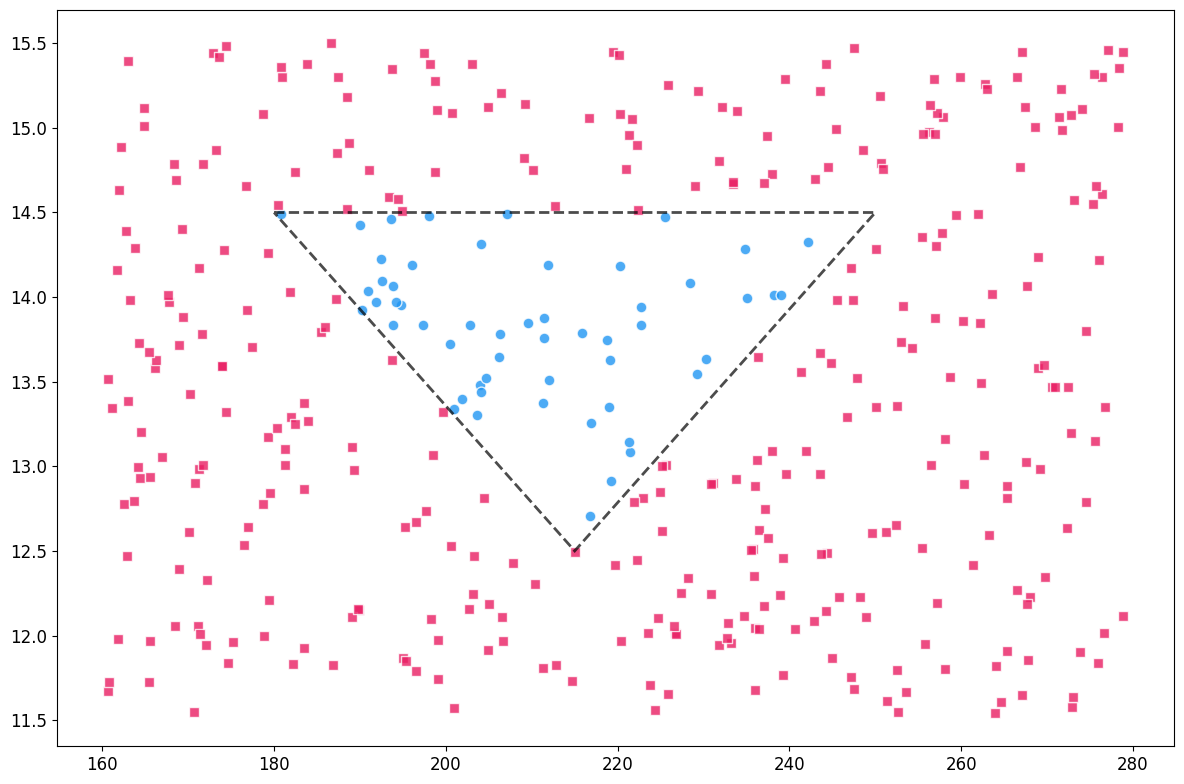

In [ ]:
def crear_datos_cafe():
    """
    Crea datos sintéticos para clasificación de tostado de café
    Clase 0: Triángulo interno (tostado perfecto)
    Clase 1: Región externa (tostado deficiente)
    """
    np.random.seed(42)

    n_samples = 400
    temperatura = np.random.uniform(160, 280, n_samples)
    duracion = np.random.uniform(11.5, 15.5, n_samples)

    vertices = np.array([
        [180, 14.5],  # Vértice izquierdo
        [250, 14.5],  # Vértice derecho
        [215, 12.5]   # Vértice superior
    ])

    def punto_en_triangulo(p, v1, v2, v3):
        def signo(p1, p2, p3):
            return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

        d1 = signo(p, v1, v2)
        d2 = signo(p, v2, v3)
        d3 = signo(p, v3, v1)

        has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
        has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)

        return not (has_neg and has_pos)

    etiquetas = np.zeros(n_samples)
    for i in range(n_samples):
        punto = np.array([temperatura[i], duracion[i]])
        if punto_en_triangulo(punto, vertices[0], vertices[1], vertices[2]):
            etiquetas[i] = 0  # Tostado perfecto
        else:
            etiquetas[i] = 1  # Tostado deficiente

    X = np.column_stack([temperatura, duracion])
    y = etiquetas.astype(int)

    return X, y, vertices

X, y, vertices_triangulo = crear_datos_cafe()

plt.figure(figsize=(12, 8))
scatter0 = plt.scatter(X[y==0, 0], X[y==0, 1], c=color_azul, marker='o', s=60,
                      edgecolors='white', linewidth=1, label='Tostado Perfecto', alpha=0.8)
scatter1 = plt.scatter(X[y==1, 0], X[y==1, 1], c=color_magenta, marker='s', s=60,
                      edgecolors='white', linewidth=1, label='Tostado Deficiente', alpha=0.8)

triangulo = plt.Polygon(vertices_triangulo, fill=False, edgecolor='black',
                       linewidth=2, linestyle='--', alpha=0.7)
plt.gca().add_patch(triangulo)

plt.tight_layout()
plt.show()

## 2. Implementación Modular de Neuronas

### Función de Activación Sigmoide

La función sigmoide es fundamental en las redes neuronales:
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

Y su derivada (necesaria para backpropagation):
$$\sigma'(z) = \sigma(z) \cdot (1 - \sigma(z))$$

### Neurona Individual

Cada neurona realiza dos operaciones:
1. **Combinación lineal**: $z = \sum_{i} w_i x_i + b$
2. **Activación**: $a = \sigma(z)$

### Importancia de la Modularidad

Implementar funciones modulares nos permite:
- **Reutilización**: Mismas funciones para todas las neuronas
- **Claridad**: Cada función tiene un propósito específico
- **Depuración**: Fácil testing y verificación
- **Extensibilidad**: Fácil agregar más capas o cambiar activaciones

In [ ]:
def sigmoide(z):
    """
    Función de activación sigmoide
    σ(z) = 1 / (1 + e^(-z))
    """
    z_clipped = np.clip(z, -250, 250)  # Prevenir overflow
    return 1 / (1 + np.exp(-z_clipped))

def derivada_sigmoide(z):
    """
    Derivada de la función sigmoide
    σ'(z) = σ(z) * (1 - σ(z))
    """
    s = sigmoide(z)
    return s * (1 - s)

def neurona_forward(x, w, b):
    """
    Propagación hacia adelante de una neurona

    Parámetros:
    x: entrada (puede ser vector para múltiples ejemplos)
    w: pesos de la neurona
    b: bias de la neurona

    Retorna:
    z: combinación lineal (w^T * x + b)
    a: activación (σ(z))
    """
    z = np.dot(x, w) + b
    a = sigmoide(z)
    return z, a

def capa_forward(X, W, b):
    """
    Propagación hacia adelante de una capa completa

    Parámetros:
    X: entradas (m ejemplos, n características)
    W: matriz de pesos (n características, k neuronas)
    b: vector de bias (k neuronas)

    Retorna:
    Z: combinaciones lineales (m ejemplos, k neuronas)
    A: activaciones (m ejemplos, k neuronas)
    """
    Z = np.dot(X, W) + b  # Broadcasting del bias
    A = sigmoide(Z)
    return Z, A

## 3. Implementación Completa de la Red Neuronal

### Arquitectura Específica

Nuestra red neuronal tendrá la siguiente estructura:

```
Entrada (2) → Capa Oculta (3) → Salida (1)
    x₁         z₁⁽¹⁾, a₁⁽¹⁾        z⁽²⁾, a⁽²⁾
    x₂         z₂⁽¹⁾, a₂⁽¹⁾        
               z₃⁽¹⁾, a₃⁽¹⁾        
```

### Parámetros de la Red

- **W₁**: Matriz de pesos de entrada a capa oculta (2×3)
- **b₁**: Vector de bias de capa oculta (3×1)
- **W₂**: Matriz de pesos de capa oculta a salida (3×1)
- **b₂**: Bias de neurona de salida (1×1)

Total: **13 parámetros** (6 pesos + 3 bias capa oculta + 3 pesos + 1 bias salida)

### Funciones de la Red

1. **Inicialización**: Parámetros aleatorios pequeños
2. **Forward Pass**: Cálculo de predicciones
3. **Función de Costo**: Binary Cross-Entropy
4. **Backward Pass**: Cálculo de gradientes
5. **Actualización**: Gradient descent

In [ ]:
class RedNeuronalSimple:
    """
    Red neuronal simple con:
    - 2 neuronas de entrada
    - 3 neuronas en capa oculta
    - 1 neurona de salida
    - Activación sigmoide en todas las neuronas
    """

    def __init__(self, seed=42):
        """Inicializar pesos y bias de la red"""
        np.random.seed(seed)

        self.W1 = np.random.randn(2, 3) * np.sqrt(2.0 / 2)
        self.b1 = np.zeros(3)

        self.W2 = np.random.randn(3, 1) * np.sqrt(2.0 / 3)
        self.b2 = np.zeros(1)

        self.historial_costo = []
        self.historial_parametros = []

    def forward(self, X):
        """
        Propagación hacia adelante

        Parámetros:
        X: entradas (m ejemplos, 2 características)

        Retorna:
        diccionario con Z1, A1, Z2, A2 (valores intermedios y finales)
        """
        m = X.shape[0]

        # Capa oculta
        Z1 = np.dot(X, self.W1) + self.b1  # (m, 3)
        A1 = sigmoide(Z1)  # (m, 3)

        # Capa de salida
        Z2 = np.dot(A1, self.W2) + self.b2  # (m, 1)
        A2 = sigmoide(Z2)  # (m, 1)

        cache = {
            'Z1': Z1, 'A1': A1,
            'Z2': Z2, 'A2': A2,
            'X': X
        }

        return A2.flatten(), cache

    def calcular_costo(self, y_true, y_pred):
        """
        Calcular Binary Cross-Entropy
        """
        m = len(y_true)
        epsilon = 1e-15
        y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)

        costo = (-1/m) * np.sum(y_true * np.log(y_pred_clipped) +
                               (1 - y_true) * np.log(1 - y_pred_clipped))
        return costo

    def backward(self, X, y_true, cache):
        """
        Retropropagación - Cálculo de gradientes

        Este es el corazón del algoritmo de aprendizaje.
        Calcula las derivadas parciales de la función de costo
        respecto a todos los parámetros de la red.
        """
        m = X.shape[0]

        Z1, A1, Z2, A2 = cache['Z1'], cache['A1'], cache['Z2'], cache['A2']

        y_pred = A2.flatten()


        dZ2 = y_pred - y_true  # (m,)
        dZ2 = dZ2.reshape(-1, 1)  # (m, 1)

        dW2 = (1/m) * np.dot(A1.T, dZ2)  # (3, 1)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)  # (1, 1)


        dA1 = np.dot(dZ2, self.W2.T)  # (m, 3)

        dZ1 = dA1 * derivada_sigmoide(Z1)  # (m, 3)

        dW1 = (1/m) * np.dot(X.T, dZ1)  # (2, 3)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)  # (1, 3)

        gradientes = {
            'dW1': dW1, 'db1': db1,
            'dW2': dW2, 'db2': db2
        }

        return gradientes

    def actualizar_parametros(self, gradientes, learning_rate):
        """
        Actualizar parámetros usando gradiente descendente
        """
        self.W1 -= learning_rate * gradientes['dW1']
        self.b1 -= learning_rate * gradientes['db1'].flatten()
        self.W2 -= learning_rate * gradientes['dW2']
        self.b2 -= learning_rate * gradientes['db2'].flatten()

    def entrenar(self, X, y, learning_rate=0.1, epochs=1000, verbose=True):
        """
        Entrenar la red neuronal
        """
        for epoch in range(epochs):
            y_pred, cache = self.forward(X)

            costo = self.calcular_costo(y, y_pred)
            self.historial_costo.append(costo)

            gradientes = self.backward(X, y, cache)

            self.actualizar_parametros(gradientes, learning_rate)

            if epoch % 100 == 0:
                parametros = {
                    'W1': self.W1.copy(), 'b1': self.b1.copy(),
                    'W2': self.W2.copy(), 'b2': self.b2.copy()
                }
                self.historial_parametros.append(parametros)

            if verbose and epoch % 200 == 0:
                precision = self.calcular_precision(X, y)
                print(f"Época {epoch:4d}: Costo = {costo:.6f}, Precisión = {precision:.3f}")

    def predecir(self, X):
        """
        Hacer predicciones
        """
        y_pred, _ = self.forward(X)
        return (y_pred >= 0.5).astype(int)

    def calcular_precision(self, X, y):
        """
        Calcular precisión de las predicciones
        """
        pred = self.predecir(X)
        return np.mean(pred == y)

    def obtener_activaciones_capa_oculta(self, X):
        """
        Obtener activaciones de la capa oculta para visualización
        """
        Z1 = np.dot(X, self.W1) + self.b1
        A1 = sigmoide(Z1)
        return Z1, A1

red = RedNeuronalSimple(seed=42)

## 4. Algoritmo de Backpropagation - Explicación Detallada

### ¿Qué es Backpropagation?

**Backpropagation** (retropropagación) es el algoritmo fundamental para entrenar redes neuronales. Su objetivo es calcular los **gradientes** de la función de costo con respecto a todos los parámetros de la red.

### Conceptos Clave

#### 1. Regla de la Cadena
El backpropagation utiliza la regla de la cadena del cálculo para propagar los gradientes desde la salida hacia las capas anteriores:

$$\frac{\partial J}{\partial w_{ij}^{(l)}} = \frac{\partial J}{\partial z_j^{(l+1)}} \cdot \frac{\partial z_j^{(l+1)}}{\partial w_{ij}^{(l)}}$$

#### 2. Gradientes Locales
Cada neurona calcula su gradiente local basado en:
- El error que recibe de la capa siguiente
- Su propia derivada de activación

### Paso a Paso del Algoritmo

#### **Paso 1: Forward Pass**
```python
# Capa oculta
Z1 = X @ W1 + b1
A1 = σ(Z1)

# Capa de salida  
Z2 = A1 @ W2 + b2
A2 = σ(Z2)
```

#### **Paso 2: Calcular Error de Salida**
```python
δ2 = A2 - y_true  # Error en la capa de salida
```

#### **Paso 3: Gradientes de Capa de Salida**
```python
dW2 = (1/m) * A1.T @ δ2
db2 = (1/m) * suma(δ2)
```

#### **Paso 4: Propagar Error hacia Atrás**
```python
δ1 = (δ2 @ W2.T) * σ'(Z1)  # Error en capa oculta
```

#### **Paso 5: Gradientes de Capa Oculta**
```python
dW1 = (1/m) * X.T @ δ1
db1 = (1/m) * suma(δ1)
```

#### **Paso 6: Actualizar Parámetros**
```python
W1 -= α * dW1
b1 -= α * db1
W2 -= α * dW2
b2 -= α * db2
```

### Intuición del Algoritmo

1. **Calculamos el error final**: ¿Qué tan lejos estamos del resultado deseado?
2. **Propagamos el error**: Distribuimos la responsabilidad del error entre todas las neuronas
3. **Calculamos gradientes**: Determinamos en qué dirección ajustar cada parámetro
4. **Actualizamos parámetros**: Damos un paso en la dirección que reduce el error

### Ventajas del Backpropagation

- **Eficiencia**: Calcula todos los gradientes en una sola pasada hacia atrás
- **Generalidad**: Funciona con cualquier arquitectura de red
- **Escalabilidad**: Maneja redes con millones de parámetros
- **Precision**: Calcula gradientes exactos, no aproximaciones

---

## 5. Visualización del Dashboard de Entrenamiento

Similar al notebook de regresión logística, crearemos un dashboard interactivo que muestre:

1. **Mapa de Probabilidades**: Evolución del límite de decisión
2. **Convergencia del Costo**: Reducción del BCE a lo largo del tiempo
3. **Métricas de Clasificación**: Precisión, matriz de confusión
4. **Distribución de Probabilidades**: Histogramas por clase
5. **Activaciones de Neuronas**: Visualización de cada neurona de la capa oculta

### Funcionalidades del Dashboard

- **Actualización en tiempo real**: Visualización durante el entrenamiento
- **Múltiples métricas**: Costo, precisión, matriz de confusión
- **Información detallada**: Progreso por época, parámetros, etc.
- **Estilo consistente**: Misma paleta de colores y diseño

In [ ]:
def visualizar_entrenamiento_red_neuronal(red, X, y, epoca, titulo="Red Neuronal"):
    """
    Visualiza el entrenamiento de la red neuronal con dashboard completo
    similar al notebook de regresión logística
    """
    clear_output(True)

    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)

    y_pred_prob, _ = red.forward(X)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    precision = np.mean(y_pred == y)
    costo_actual = red.calcular_costo(y, y_pred_prob)

    ax1 = fig.add_subplot(gs[:, 0:2])

    h = 0.1
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    malla_points = np.c_[xx.ravel(), yy.ravel()]
    z_malla, _ = red.forward(malla_points)
    z_malla = z_malla.reshape(xx.shape)

    contour = ax1.contourf(xx, yy, z_malla, levels=50, alpha=0.8, cmap='RdYlBu')

    ax1.contour(xx, yy, z_malla, levels=[0.1, 0.3, 0.5, 0.7, 0.9],
               colors='white', linewidths=[1, 1, 3, 1, 1], alpha=0.8)

    ax1.scatter(X[y==0, 0], X[y==0, 1], c=color_azul, marker='o', s=60,
               edgecolors='white', linewidth=1, label='Tostado Perfecto', alpha=0.8, zorder=5)
    ax1.scatter(X[y==1, 0], X[y==1, 1], c=color_magenta, marker='s', s=60,
               edgecolors='white', linewidth=1, label='Tostado Deficiente', alpha=0.8, zorder=5)

    ax1.set_xlabel('Temperatura (normalizada)', fontsize=14, color='#333333')
    ax1.set_ylabel('Duración (normalizada)', fontsize=14, color='#333333')
    ax1.set_title(f'{titulo} - Época {epoca}', fontsize=16, fontweight='bold', color='#333333')
    ax1.legend(fontsize=12, loc='upper left')
    ax1.set_facecolor('#FAFAFA')

    cbar = plt.colorbar(contour, ax=ax1)
    cbar.set_label('P(Tostado Deficiente)', rotation=270, labelpad=15, fontsize=12)

    ax2 = fig.add_subplot(gs[0, 2])
    if len(red.historial_costo) > 1:
        ax2.plot(red.historial_costo, color=color_violeta, linewidth=3, alpha=0.8)
        ax2.set_xlabel('Época', color='#333333', fontsize=12)
        ax2.set_ylabel('Costo BCE', color='#333333', fontsize=12)
        ax2.set_title('Convergencia del Costo', color='#333333', fontweight='bold', fontsize=14)
        ax2.grid(True, alpha=0.3, color='#CCCCCC')
        ax2.set_facecolor('#FAFAFA')

        if len(red.historial_costo) > 1:
            mejora = ((red.historial_costo[0] - red.historial_costo[-1]) / red.historial_costo[0]) * 100
            ax2.text(0.02, 0.98, f'Mejora: {mejora:.1f}%', transform=ax2.transAxes,
                    verticalalignment='top', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax2.text(0.5, 0.5, 'Entrenando...', ha='center', va='center',
                transform=ax2.transAxes, fontsize=14, color='#666666')
        ax2.set_title('Convergencia del Costo', color='#333333', fontweight='bold', fontsize=14)

    ax3 = fig.add_subplot(gs[0, 3])

    ax3.text(0.1, 0.85, f'Precisión: {precision:.1%}', fontsize=16, fontweight='bold',
            transform=ax3.transAxes, color=color_magenta)
    ax3.text(0.1, 0.7, f'Costo: {costo_actual:.4f}', fontsize=14,
            transform=ax3.transAxes, color='#333333')
    ax3.text(0.1, 0.55, f'Época: {epoca}', fontsize=14,
            transform=ax3.transAxes, color='#333333')
    ax3.text(0.1, 0.4, f'Parámetros: 13', fontsize=14,
            transform=ax3.transAxes, color='#333333')

    progress_width = precision
    ax3.barh(0.15, progress_width, height=0.08, color=color_cyan, alpha=0.7,
            transform=ax3.transAxes)
    ax3.text(0.1, 0.1, f'Progreso: {precision:.1%}', fontsize=12,
            transform=ax3.transAxes, color='#333333')

    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.set_title('Métricas del Modelo', color='#333333', fontweight='bold', fontsize=14)
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[1, 2])

    prob_clase_0 = y_pred_prob[y == 0]
    prob_clase_1 = y_pred_prob[y == 1]

    ax4.hist(prob_clase_0, bins=15, alpha=0.7, color=color_azul,
            label='Tostado Perfecto', density=True)
    ax4.hist(prob_clase_1, bins=15, alpha=0.7, color=color_magenta,
            label='Tostado Deficiente', density=True)
    ax4.axvline(x=0.5, color='white', linestyle='--', linewidth=2, label='Umbral')

    ax4.set_xlabel('Probabilidad', fontsize=12, color='#333333')
    ax4.set_ylabel('Densidad', fontsize=12, color='#333333')
    ax4.set_title('Distribución de Probabilidades', fontsize=14, fontweight='bold', color='#333333')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3, color='#CCCCCC')
    ax4.set_facecolor('#FAFAFA')

    ax5 = fig.add_subplot(gs[1, 3])

    cm = confusion_matrix(y, y_pred)

    im = ax5.imshow(cm, interpolation='nearest', cmap='Blues', alpha=0.8)
    ax5.set_title('Matriz de Confusión', fontsize=14, fontweight='bold', color='#333333')

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax5.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontsize=16, fontweight='bold',
                    color="white" if cm[i, j] > thresh else "black")

    ax5.set_ylabel('Clase Real', fontsize=12, color='#333333')
    ax5.set_xlabel('Clase Predicha', fontsize=12, color='#333333')
    ax5.set_xticks([0, 1])
    ax5.set_yticks([0, 1])
    ax5.set_xticklabels(['Perfecto', 'Deficiente'])
    ax5.set_yticklabels(['Perfecto', 'Deficiente'])

    ax6 = fig.add_subplot(gs[2, 2:4])

    Z1, A1 = red.obtener_activaciones_capa_oculta(X)

    xx_sub, yy_sub = np.meshgrid(np.arange(x_min, x_max, h*2),
                                 np.arange(y_min, y_max, h*2))
    malla_sub = np.c_[xx_sub.ravel(), yy_sub.ravel()]
    Z1_malla, A1_malla = red.obtener_activaciones_capa_oculta(malla_sub)

    for i in range(3):
        activation_i = A1_malla[:, i].reshape(xx_sub.shape)

        if i == 0:
            contour_i = ax6.contourf(xx_sub, yy_sub, activation_i,
                                   levels=10, alpha=0.3, cmap='Reds')
        elif i == 1:
            contour_i = ax6.contourf(xx_sub, yy_sub, activation_i,
                                   levels=10, alpha=0.3, cmap='Greens')
        else:
            contour_i = ax6.contourf(xx_sub, yy_sub, activation_i,
                                   levels=10, alpha=0.3, cmap='Blues')

        ax6.contour(xx_sub, yy_sub, activation_i, levels=3,
                   colors='white', alpha=0.6, linewidths=1)

    ax6.scatter(X[y==0, 0], X[y==0, 1], c=color_azul, marker='o', s=40,
               edgecolors='white', linewidth=1, alpha=0.8, zorder=5)
    ax6.scatter(X[y==1, 0], X[y==1, 1], c=color_magenta, marker='s', s=40,
               edgecolors='white', linewidth=1, alpha=0.8, zorder=5)

    ax6.set_xlabel('Temperatura (normalizada)', fontsize=12, color='#333333')
    ax6.set_ylabel('Duración (normalizada)', fontsize=12, color='#333333')
    ax6.set_title('Activaciones de Neuronas Ocultas (Superpuestas)',
                 fontsize=14, fontweight='bold', color='#333333')
    ax6.set_facecolor('#FAFAFA')

    fig.patch.set_facecolor('white')

    #plt.tight_layout()
    plt.show()

    errores = np.sum(y_pred != y)
    print(f"Época {epoca:4d}: Costo = {costo_actual:.6f}, Precisión = {precision:.3f}, Errores = {errores}/{len(y)}")

def entrenar_con_visualizacion(red, X, y, learning_rate=0.1, epochs=1000, mostrar_cada=200):
    """
    Entrena la red neuronal con visualización del progreso
    """

    for epoch in range(epochs):
        y_pred, cache = red.forward(X)

        costo = red.calcular_costo(y, y_pred)
        red.historial_costo.append(costo)

        gradientes = red.backward(X, y, cache)

        red.actualizar_parametros(gradientes, learning_rate)

        if epoch % 100 == 0:
            parametros = {
                'W1': red.W1.copy(), 'b1': red.b1.copy(),
                'W2': red.W2.copy(), 'b2': red.b2.copy()
            }
            red.historial_parametros.append(parametros)

        if epoch % mostrar_cada == 0:
            visualizar_entrenamiento_red_neuronal(red, X, y, epoch)

    return red

## 6. Visualización Individual de Neuronas

Una de las ventajas de las redes neuronales es que podemos visualizar qué está aprendiendo cada neurona individual. Esto nos ayuda a entender:

1. **Especialización**: Cada neurona aprende a detectar diferentes patrones
2. **Colaboración**: Las neuronas trabajan juntas para resolver el problema
3. **Límites de decisión**: Cómo cada neurona contribuye al resultado final
4. **Interpretabilidad**: Qué características están siendo detectadas

### Funcionalidad de cada Neurona

- **Neurona 1**: Puede especializarse en detectar una región específica
- **Neurona 2**: Puede aprender a identificar otra característica
- **Neurona 3**: Puede combinar información de las anteriores

La neurona de salida luego combina estas representaciones para tomar la decisión final.

In [ ]:
def visualizar_neuronas_individuales(red, X, y, titulo="Neuronas de la Capa Oculta"):
    """
    Visualiza las activaciones de cada neurona individual de la capa oculta
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    h = 0.1
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    malla_points = np.c_[xx.ravel(), yy.ravel()]
    Z1_malla, A1_malla = red.obtener_activaciones_capa_oculta(malla_points)

    colores = ['Reds', 'Greens', 'Blues']
    nombres = ['Neurona 1', 'Neurona 2', 'Neurona 3']

    for i in range(3):
        ax = axes[i]

        activation_i = A1_malla[:, i].reshape(xx.shape)

        contour = ax.contourf(xx, yy, activation_i, levels=20, alpha=0.8, cmap=colores[i])

        ax.contour(xx, yy, activation_i, levels=10, colors='white', alpha=0.6, linewidths=1)

        ax.scatter(X[y==0, 0], X[y==0, 1], c=color_azul, marker='o', s=60,
                  edgecolors='white', linewidth=1, alpha=0.8, zorder=5)
        ax.scatter(X[y==1, 0], X[y==1, 1], c=color_magenta, marker='s', s=60,
                  edgecolors='white', linewidth=1, alpha=0.8, zorder=5)

        ax.set_xlabel('Temperatura (normalizada)', fontsize=12, color='#333333')
        ax.set_ylabel('Duración (normalizada)', fontsize=12, color='#333333')
        ax.set_title(f'{nombres[i]}', fontsize=14, fontweight='bold', color='#333333')
        ax.set_facecolor('#FAFAFA')

        cbar = plt.colorbar(contour, ax=ax)
        cbar.set_label('Activación', rotation=270, labelpad=15, fontsize=10)

        Z1_datos, A1_datos = red.obtener_activaciones_capa_oculta(X)
        activacion_promedio = np.mean(A1_datos[:, i])

        ax.text(0.02, 0.98, f'Activación promedio: {activacion_promedio:.3f}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=10)

    plt.suptitle(titulo, fontsize=16, fontweight='bold', color='#333333')
    #plt.tight_layout()
    plt.show()

    print(f"\n=== ANÁLISIS DE NEURONAS INDIVIDUALES ===")
    Z1_datos, A1_datos = red.obtener_activaciones_capa_oculta(X)

    for i in range(3):
        print(f"\nNeurona {i+1}:")
        print(f"  Pesos de entrada: w1={red.W1[0,i]:.3f}, w2={red.W1[1,i]:.3f}")
        print(f"  Bias: {red.b1[i]:.3f}")
        print(f"  Activación promedio: {np.mean(A1_datos[:, i]):.3f}")
        print(f"  Rango de activación: [{np.min(A1_datos[:, i]):.3f}, {np.max(A1_datos[:, i]):.3f}]")
        print(f"  Peso hacia salida: {red.W2[i,0]:.3f}")

        print(f"  Especialización: {'Alta' if abs(red.W2[i,0]) > 0.5 else 'Media' if abs(red.W2[i,0]) > 0.2 else 'Baja'}")

def analizar_resultados_red_neuronal(red, X, y):
    """
    Analiza los resultados finales de la red neuronal entrenada
    """
    print(f"\n{'='*60}")
    print(f"🎯 ANÁLISIS FINAL DE LA RED NEURONAL")
    print(f"{'='*60}")

    y_pred_prob, _ = red.forward(X)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    precision = np.mean(y_pred == y)
    costo_final = red.calcular_costo(y, y_pred_prob)

    print(f"\nMétricas finales:")
    print(f"  Precisión: {precision:.3f} ({precision*100:.1f}%)")
    print(f"  Costo final: {costo_final:.6f}")
    print(f"  Errores: {np.sum(y_pred != y)}/{len(y)}")

    if len(red.historial_costo) > 1:
        mejora_costo = ((red.historial_costo[0] - red.historial_costo[-1]) / red.historial_costo[0]) * 100
        print(f"  Mejora en costo: {mejora_costo:.1f}%")

    print(f"\nAnálisis de parámetros:")
    print(f"  Magnitud promedio W1: {np.mean(np.abs(red.W1)):.3f}")
    print(f"  Magnitud promedio W2: {np.mean(np.abs(red.W2)):.3f}")
    print(f"  Magnitud promedio b1: {np.mean(np.abs(red.b1)):.3f}")
    print(f"  Magnitud promedio b2: {np.abs(red.b2[0]):.3f}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    prob_clase_0 = y_pred_prob[y == 0]
    prob_clase_1 = y_pred_prob[y == 1]

    plt.hist(prob_clase_0, bins=20, alpha=0.7, color=color_azul,
            label='Tostado Perfecto', density=True)
    plt.hist(prob_clase_1, bins=20, alpha=0.7, color=color_magenta,
            label='Tostado Deficiente', density=True)
    plt.axvline(x=0.5, color='white', linestyle='--', linewidth=2, label='Umbral')
    plt.xlabel('Probabilidad P(Deficiente)', fontsize=12)
    plt.ylabel('Densidad', fontsize=12)
    plt.title('Distribución Final de Probabilidades', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(red.historial_costo, color=color_violeta, linewidth=2)
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Costo BCE', fontsize=12)
    plt.title('Evolución del Costo', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    if precision > 0.95:
        print(f"\n🎉 ¡EXCELENTE! La red neuronal logró una precisión excepcional.")
        print(f"   La arquitectura 2-3-1 es perfecta para este problema.")
    elif precision > 0.85:
        print(f"\n✅ ¡MUY BUENO! La red neuronal superó significativamente a métodos lineales.")
        print(f"   El backpropagation convergió exitosamente.")
    elif precision > 0.75:
        print(f"\n👍 BUENO: La red neuronal muestra mejoras sobre métodos simples.")
        print(f"   Considera aumentar épocas o ajustar learning rate.")
    else:
        print(f"\n⚠️  REGULAR: La red necesita más entrenamiento o ajustes.")
        print(f"   Revisa los parámetros de entrenamiento.")

    return {
        'precision': precision,
        'costo_final': costo_final,
        'mejora_costo': mejora_costo if len(red.historial_costo) > 1 else 0
    }


## 7. Entrenamiento de la Red Neuronal

Ahora vamos a entrenar nuestra red neuronal con el dataset de tostado de café. Utilizaremos:

- **Tasa de aprendizaje**: 0.3 (mayor que regresión logística por la complejidad)
- **Épocas**: 2000 (suficientes para convergencia)
- **Visualización**: Cada 400 épocas para ver el progreso

### Expectativas

Con esta arquitectura esperamos:
- **Precisión > 90%**: Superando métodos lineales
- **Límite de decisión curvo**: Adaptándose al patrón triangular
- **Convergencia estable**: Reducción consistente del costo
- **Especialización de neuronas**: Cada neurona detectando características únicas

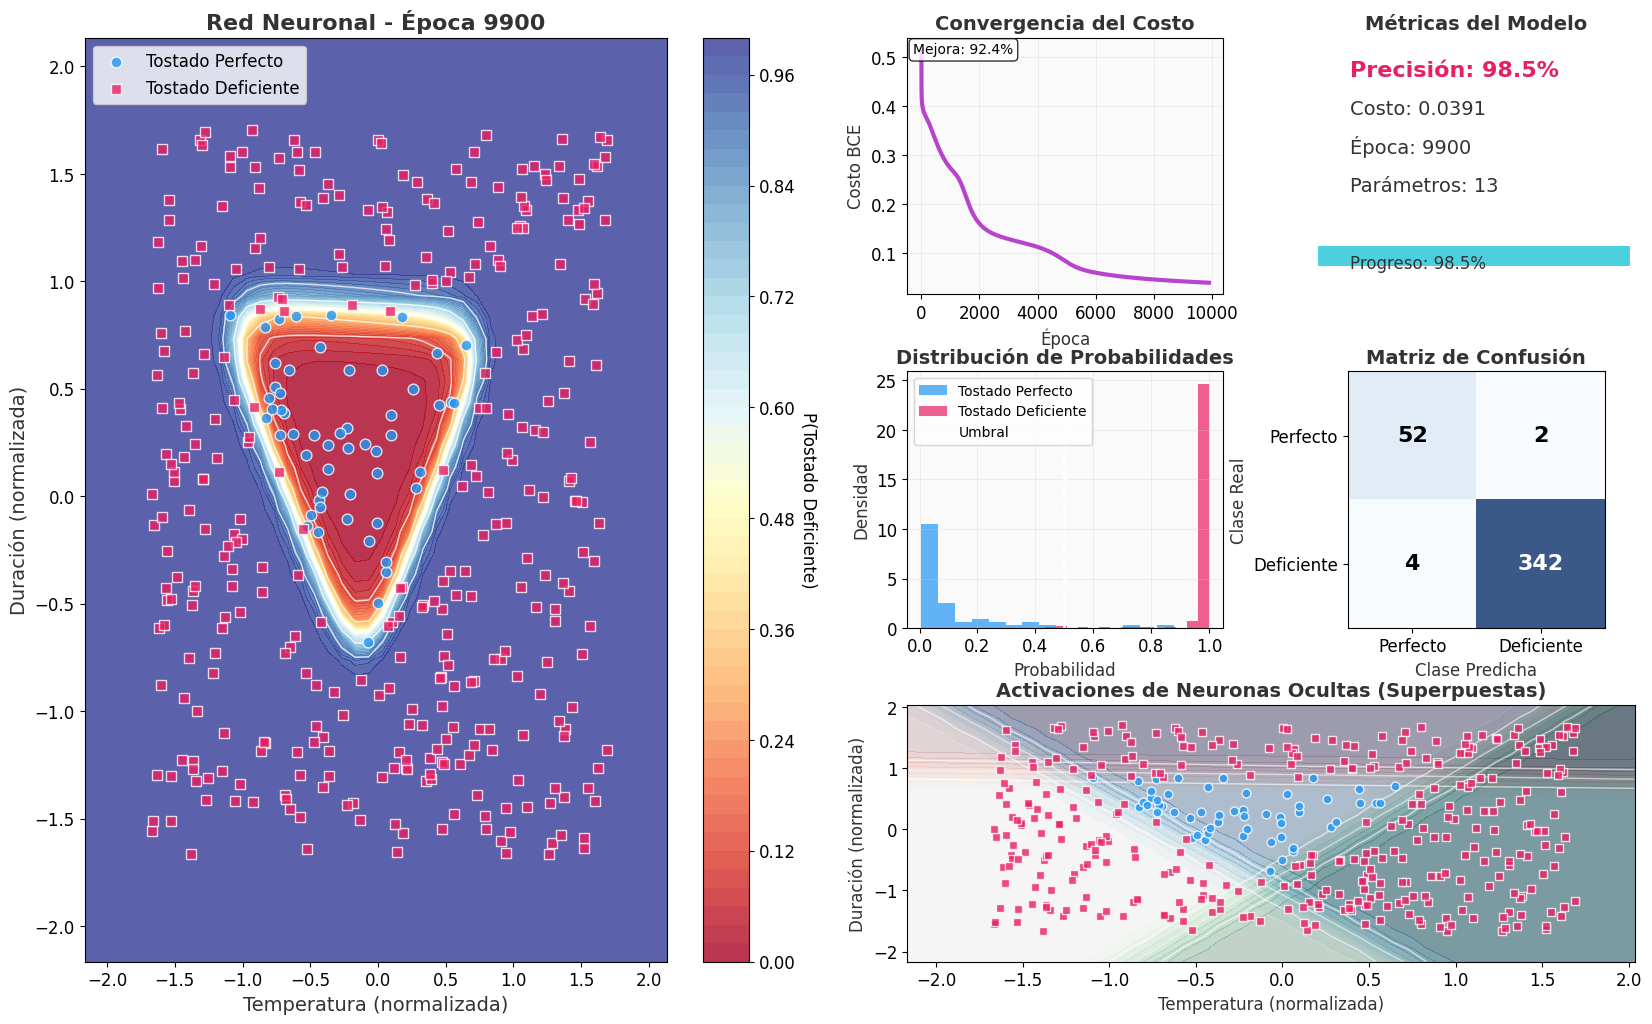

Época 9900: Costo = 0.039120, Precisión = 0.985, Errores = 6/400


In [ ]:
X_normalizado = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

red = RedNeuronalSimple(seed=42)

learning_rate = 0.5
epochs = 10000
mostrar_cada = 100


red_entrenada = entrenar_con_visualizacion(red, X_normalizado, y,
                                          learning_rate=learning_rate,
                                          epochs=epochs,
                                          mostrar_cada=mostrar_cada)

## 8. Análisis Individual de Neuronas

Después del entrenamiento, es crucial entender qué aprendió cada neurona. Esto nos permite:

1. **Verificar la especialización**: Cada neurona debe haber aprendido a detectar características específicas
2. **Entender la colaboración**: Cómo las neuronas trabajan juntas para resolver el problema
3. **Validar el aprendizaje**: Confirmar que la red no solo memoriza, sino que generaliza

### Interpretación de los Mapas de Activación

- **Regiones rojas/altas**: Donde la neurona se activa fuertemente
- **Regiones azules/bajas**: Donde la neurona tiene poca activación
- **Patrones diferentes**: Cada neurona debería mostrar un patrón único

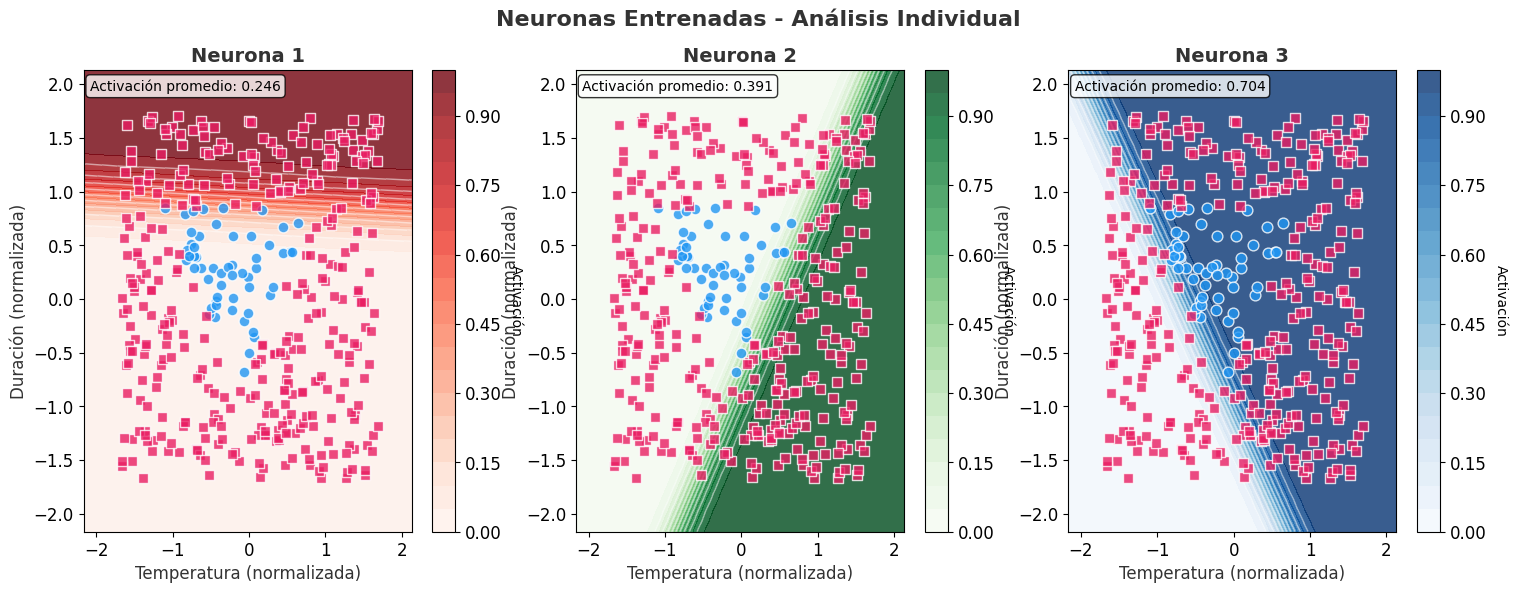


=== ANÁLISIS DE NEURONAS INDIVIDUALES ===

Neurona 1:
  Pesos de entrada: w1=0.278, w2=7.824
  Bias: -7.001
  Activación promedio: 0.246
  Rango de activación: [0.000, 0.999]
  Peso hacia salida: 12.374
  Especialización: Alta

Neurona 2:
  Pesos de entrada: w1=8.036, w2=-4.777
  Bias: -3.473
  Activación promedio: 0.391
  Rango de activación: [0.000, 1.000]
  Peso hacia salida: 12.770
  Especialización: Alta

Neurona 3:
  Pesos de entrada: w1=8.120, w2=5.161
  Bias: 5.518
  Activación promedio: 0.704
  Rango de activación: [0.000, 1.000]
  Peso hacia salida: -11.393
  Especialización: Alta


In [ ]:
# Visualizar neuronas individuales
visualizar_neuronas_individuales(red_entrenada, X_normalizado, y,
                                titulo="Neuronas Entrenadas - Análisis Individual")

## 9. Análisis Final y Conclusiones

Para completar nuestro análisis, vamos a:

1. **Evaluar el rendimiento final**: Métricas completas del modelo
2. **Analizar la convergencia**: Evolución del costo y precisión
3. **Comparar con métodos lineales**: Ventajas de la red neuronal
4. **Interpretar los resultados**: Qué significa para el problema del café

### Métricas Clave a Evaluar

- **Precisión**: Porcentaje de clasificaciones correctas
- **Distribución de probabilidades**: Separación entre clases
- **Convergencia**: Estabilidad del entrenamiento
- **Especialización**: Análisis de cada neurona